In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_pickle('./finefood_dataset_cleaned.pkl')
df.head()

,score,summary,text,text_cleaned,summary_cleaned,word_counts_summary,word_counts_text,word_counts_summary_cleaned,word_counts_text_cleaned
0,5.0,good quality dog food,i have bought several of the vitality canned d...,bought sever vital can dog food product found ...,good qualiti dog food,4,48,4,23
1,1.0,not as advertised,product arrived labeled as jumbo salted peanut...,product arriv label jumbo salt peanut peanut a...,advertis,3,31,1,18
2,4.0,"""delight"" says it all",this is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...,delight say,4,94,2,39
3,2.0,cough medicine,if you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...,cough medicin,2,41,2,18
4,5.0,great taffy,great taffy at a great price. there was a wid...,great taffi great price wide assort yummi taff...,great taffi,2,27,2,13


In [3]:
df.shape

(395006, 9)

Sample dataset

In [4]:
df_sampled = df.sample(n=50000, random_state = 123)
df_sampled.shape

(50000, 9)

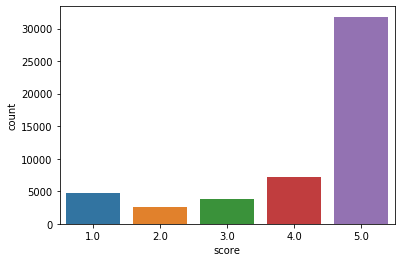

In [5]:
sns.countplot(df_sampled.score)

In [7]:
indexes = df_sampled.index[df_sampled['score'] == '5.0'].tolist()
drop_indices = np.random.choice(indexes, 24000, replace=False)
df_sampled = df_sampled.drop(drop_indices)
df_sampled.shape

(26000, 9)

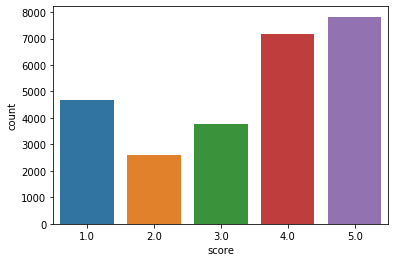

In [9]:
sns.countplot(df_sampled.score)

In [10]:
df["score"] = df['score'].astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395006 entries, 0 to 568453
Data columns (total 9 columns):
score                          395006 non-null float64
summary                        395006 non-null object
text                           395006 non-null object
text_cleaned                   395006 non-null object
summary_cleaned                395006 non-null object
word_counts_summary            395006 non-null int64
word_counts_text               395006 non-null int64
word_counts_summary_cleaned    395006 non-null int64
word_counts_text_cleaned       395006 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 40.1+ MB


## Encode score for multiclass classification 

In [12]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(df['score'])
encoded_score = encoder.transform(df['score'])
# convert integers to dummy variables (i.e. one hot encoded)
dummy_score = np_utils.to_categorical(encoded_score)

Using TensorFlow backend.


## Word2vec embedding

In [13]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [14]:
review_lines = list()
lines = df_sampled['text_cleaned'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    review_lines.append(tokens)

len(review_lines)

26000

In [15]:
import gensim

embedding_dimension=100

model = gensim.models.Word2Vec(sentences = review_lines, size=embedding_dimension, window=5, workers=4, min_count=1)

words = list(model.wv.vocab)
print('Vocab size: %d' % len(words))


Vocab size: 21933


In [16]:
model.wv.save_word2vec_format('finefoods_w2v_embedding.txt', binary=False)

Load as dictionary

In [17]:
import numpy as np

embedding_index = {}
f = open("finefoods_w2v_embedding.txt", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs
f.close()

#### Tockenize

In [18]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

In [19]:
word_index = tokenizer_obj.word_index
print("Found %s unique tokens." % len(word_index))

Found 21933 unique tokens.


In [20]:
max_length = max([len(s.split()) for s in df_sampled['text_cleaned']])
print("Max length %d " % max_length)

review_pad = pad_sequences(sequences, maxlen=max_length)
score = dummy_score

print("Shape review: ", review_pad.shape)
print("Shape score: ", score.shape)

Max length 1026 
Shape review:  (26000, 1026)
Shape score:  (395006, 5)


Map embeddings from the loaded word2vec model for each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.

In [21]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dimension))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(num_words)

21934


## Build Model

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

In [23]:
model = Sequential()
embedding_layer = Embedding(num_words,
                           embedding_dimension,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length = max_length,
                           trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2)) # Gated recurrent unit - LSTM for smaller dataset, lower parameters, good for sequences - optional
#model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1026, 100)         2193400   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,206,333
Trainable params: 12,933
Non-trainable params: 2,193,400
_________________________________________________________________
None


Split dataset 

In [24]:
validation_split = 0.2

indicies = np.arange(review_pad.shape[0])
np.random.shuffle(indicies)
review_pad = review_pad[indicies]
score = score[indicies]
num_validation_samples = int(validation_split * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]

y_train = score[:-num_validation_samples]
y_test = score[-num_validation_samples:]

print("Shapes X_train_pad, X_test_pad, y_train, y_test: ", X_train_pad.shape, X_test_pad.shape, y_train.shape, y_test.shape)

Shapes X_train_pad, X_test_pad, y_train, y_test:  (20800, 1026) (5200, 1026) (20800, 5) (5200, 5)


In [25]:
print("Training")
model.fit(X_train_pad, y_train, batch_size=512, epochs=5, validation_data=(X_test_pad, y_test), verbose=1)

Training
Train on 20800 samples, validate on 5200 samples
Epoch 1/5
 4608/20800 [=====>........................] - ETA: 1:06 - loss: nan - accuracy: 0.1633                  

KeyboardInterrupt: 